In [4]:
import pandas as pd
import os
import requests
from bs4 import BeautifulSoup
from urllib.parse import urljoin
import time

# dl all data from data.gouv in 2023 in the department 31

In [3]:
url = 'https://files.data.gouv.fr/geo-dvf/latest/csv/2023/communes/31/'

In [11]:
download_folder = r'C:\Users\melan\Desktop\DeveloppementInfo\Portfolio\PortfolioData\House_Price_Toulouse\CSV'

In [13]:
response = requests.get(url)
response.raise_for_status()

In [15]:
soup = BeautifulSoup(response.content, 'html.parser')

In [17]:
csv_links = soup.find_all('a', href=True)
csv_links = [link for link in csv_links if link['href'].endswith('.csv')]

In [ ]:
for link in csv_links:
    file_url = urljoin(url, link['href'])
    file_name = os.path.basename(link['href'])
    file_path = os.path.join(download_folder, file_name)
    
    file_response = requests.get(file_url)
    file_response.raise_for_status()
    
    with open(file_path, 'wb') as file:
        file.write(file_response.content)
    
print('Téléchargement terminé.')

In [ ]:
for link in csv_links:
    file_url = urljoin(url, link['href'])
    file_name = os.path.basename(link['href'])
    file_path = os.path.join(download_folder, file_name)
    
    file_response = requests.get(file_url)
    file_response.raise_for_status()
    
    with open(file_path, 'wb') as file:
        file.write(file_response.content)
    
print('Téléchargement terminé.')

## concate in one file 

In [29]:
dfs = []
for file_name in os.listdir(download_folder):
    if file_name.endswith('.csv'):
        file_path = os.path.join(download_folder, file_name)
        # Lire chaque fichier CSV et l'ajouter à la liste des DataFrames
        df = pd.read_csv(file_path)
        dfs.append(df)
        
concatenated_df = pd.concat(dfs, ignore_index=True)
output_file = os.path.join(download_folder, 'concatenated.csv')
concatenated_df.to_csv(output_file, index=False)

print(f'Tous les fichiers CSV ont été concaténés en : {output_file}')

Tous les fichiers CSV ont été concaténés en : C:\Users\melan\Desktop\DeveloppementInfo\Portfolio\PortfolioData\House_Price_Toulouse\CSV\concatenated.csv


# read csv

In [43]:
df = pd.read_csv("CSV/concatenated.csv")
df.head(10)

,id_mutation,date_mutation,numero_disposition,nature_mutation,valeur_fonciere,adresse_numero,adresse_suffixe,adresse_nom_voie,adresse_code_voie,code_postal,...,type_local,surface_reelle_bati,nombre_pieces_principales,code_nature_culture,nature_culture,code_nature_culture_speciale,nature_culture_speciale,surface_terrain,longitude,latitude
0,2023-387434,2023-03-04,1,Vente,150000.0,62.0,A,BOIS DE BONSOM,B006,31230.0,...,Maison,149.0,6.0,VI,vignes,NaN,NaN,1296.0,0.875032,43.36364
1,2023-387434,2023-03-04,1,Vente,150000.0,62.0,A,BOIS DE BONSOM,B006,31230.0,...,Dépendance,NaN,0.0,VI,vignes,NaN,NaN,1296.0,0.875032,43.36364
2,2023-387434,2023-03-04,1,Vente,150000.0,62.0,A,BOIS DE BONSOM,B006,31230.0,...,Dépendance,NaN,0.0,VI,vignes,NaN,NaN,1296.0,0.875032,43.36364
3,2023-387434,2023-03-04,1,Vente,150000.0,62.0,A,BOIS DE BONSOM,B006,31230.0,...,Maison,149.0,6.0,AG,terrains d'agrément,PARC,Parc,750.0,0.875032,43.36364
4,2023-387434,2023-03-04,1,Vente,150000.0,62.0,A,BOIS DE BONSOM,B006,31230.0,...,Dépendance,NaN,0.0,AG,terrains d'agrément,PARC,Parc,750.0,0.875032,43.36364
5,2023-387434,2023-03-04,1,Vente,150000.0,62.0,A,BOIS DE BONSOM,B006,31230.0,...,Dépendance,NaN,0.0,AG,terrains d'agrément,PARC,Parc,750.0,0.875032,43.36364
6,2023-387434,2023-03-04,1,Vente,150000.0,62.0,A,BOIS DE BONSOM,B006,31230.0,...,Maison,149.0,6.0,AG,terrains d'agrément,PARC,Parc,539.0,0.875032,43.36364
7,2023-387434,2023-03-04,1,Vente,150000.0,62.0,A,BOIS DE BONSOM,B006,31230.0,...,Dépendance,NaN,0.0,AG,terrains d'agrément,PARC,Parc,539.0,0.875032,43.36364
8,2023-387434,2023-03-04,1,Vente,150000.0,62.0,A,BOIS DE BONSOM,B006,31230.0,...,Dépendance,NaN,0.0,AG,terrains d'agrément,PARC,Parc,539.0,0.875032,43.36364
9,2023-387434,2023-03-04,1,Vente,150000.0,62.0,A,BOIS DE BONSOM,B006,31230.0,...,Maison,149.0,6.0,J,jardins,NaN,NaN,756.0,0.875032,43.36364


In [11]:
len(df)

73135

## cleaning

### lines : keep only House and Appartment, drop the duplicate

In [45]:
df = df[(df.type_local=="Maison")|(df.type_local=="Appartement")].reset_index()

In [47]:
df.duplicated(subset=['id_mutation'])

0        False
1         True
2         True
3         True
4         True
         ...  
22570    False
22571     True
22572    False
22573    False
22574     True
Length: 22575, dtype: bool

In [49]:
df = df.drop_duplicates(subset=['id_mutation'])

In [51]:
df = df[df.nature_mutation=='Vente']

In [53]:
len(df)

18786

### columns : drop

In [55]:
df=df.dropna(axis=1, how='all')

In [57]:
df = df[['date_mutation','valeur_fonciere','code_postal','nom_commune','type_local','surface_reelle_bati','nombre_pieces_principales','nature_culture','nature_culture_speciale','surface_terrain']]

In [59]:
df

,date_mutation,valeur_fonciere,code_postal,nom_commune,type_local,surface_reelle_bati,nombre_pieces_principales,nature_culture,nature_culture_speciale,surface_terrain
0,2023-03-04,150000.0,31230.0,Agassac,Maison,149.0,6.0,vignes,NaN,1296.0
5,2023-10-27,150000.0,31230.0,Agassac,Appartement,66.0,3.0,sols,NaN,359.0
7,2023-04-14,90000.0,31550.0,Aignes,Maison,36.0,1.0,sols,NaN,1758.0
8,2023-04-19,186570.0,31280.0,Aigrefeuille,Appartement,63.0,3.0,NaN,NaN,NaN
9,2023-04-24,845000.0,31280.0,Aigrefeuille,Maison,360.0,7.0,terrains d'agrément,Parc,1794.0
...,...,...,...,...,...,...,...,...,...,...
22567,2023-12-05,644700.0,31330.0,Larra,Maison,293.0,7.0,terres,NaN,35040.0
22568,2023-12-14,515100.0,31330.0,Larra,Appartement,159.0,4.0,terres,NaN,31425.0
22570,2023-12-26,453100.0,31330.0,Larra,Maison,139.0,6.0,sols,NaN,1500.0
22572,2023-02-14,120000.0,31230.0,Cazac,Maison,102.0,2.0,sols,NaN,1859.0


In [61]:
#reset_index
df = df.reset_index(drop=True)
df

,date_mutation,valeur_fonciere,code_postal,nom_commune,type_local,surface_reelle_bati,nombre_pieces_principales,nature_culture,nature_culture_speciale,surface_terrain
0,2023-03-04,150000.0,31230.0,Agassac,Maison,149.0,6.0,vignes,NaN,1296.0
1,2023-10-27,150000.0,31230.0,Agassac,Appartement,66.0,3.0,sols,NaN,359.0
2,2023-04-14,90000.0,31550.0,Aignes,Maison,36.0,1.0,sols,NaN,1758.0
3,2023-04-19,186570.0,31280.0,Aigrefeuille,Appartement,63.0,3.0,NaN,NaN,NaN
4,2023-04-24,845000.0,31280.0,Aigrefeuille,Maison,360.0,7.0,terrains d'agrément,Parc,1794.0
...,...,...,...,...,...,...,...,...,...,...
18781,2023-12-05,644700.0,31330.0,Larra,Maison,293.0,7.0,terres,NaN,35040.0
18782,2023-12-14,515100.0,31330.0,Larra,Appartement,159.0,4.0,terres,NaN,31425.0
18783,2023-12-26,453100.0,31330.0,Larra,Maison,139.0,6.0,sols,NaN,1500.0
18784,2023-02-14,120000.0,31230.0,Cazac,Maison,102.0,2.0,sols,NaN,1859.0


In [63]:
#save version df final
df.to_csv("HousePrice_Tls_2023.csv",index=False)

### clean date, outliers, NA

In [353]:
df = pd.read_csv("HousePrice_Tls_2023.csv")

In [355]:
# separer année/mois
df.date_mutation = pd.to_datetime(df.date_mutation)

In [357]:
df.date_mutation.dtypes

dtype('<M8[ns]')

In [359]:
df['year'] = df['date_mutation'].dt.year
df['month'] = df['date_mutation'].dt.month

In [361]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18786 entries, 0 to 18785
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   date_mutation              18786 non-null  datetime64[ns]
 1   valeur_fonciere            18775 non-null  float64       
 2   code_postal                18786 non-null  float64       
 3   nom_commune                18786 non-null  object        
 4   type_local                 18786 non-null  object        
 5   surface_reelle_bati        18786 non-null  float64       
 6   nombre_pieces_principales  18786 non-null  float64       
 7   nature_culture             8199 non-null   object        
 8   nature_culture_speciale    387 non-null    object        
 9   surface_terrain            8199 non-null   float64       
 10  year                       18786 non-null  int32         
 11  month                      18786 non-null  int32         
dtypes: d

In [363]:
#code postal in a string
df['code_postal'] = df['code_postal'].apply(str)
df['code_postal'] = df['code_postal'].str.split('.').str[0]
df['code_postal']

0        31230
1        31230
2        31550
3        31280
4        31280
         ...  
18781    31330
18782    31330
18783    31330
18784    31230
18785    31230
Name: code_postal, Length: 18786, dtype: object

In [365]:
#nature_cultutre_spé est ce necessaire, fusion avec nature ou drop ? 
df['nature_culture_speciale'].value_counts()

nature_culture_speciale
Parc              341
Jardin potager     37
Pré marais          4
Rue                 2
Ruines              1
Pâture plantée      1
Pacage              1
Name: count, dtype: int64

In [367]:
df[df.nature_culture == "terrains d'agrément"]['nature_culture_speciale'].value_counts()

nature_culture_speciale
Parc    341
Name: count, dtype: int64

In [369]:
df[df.nature_culture_speciale == "Jardin potager"]

,date_mutation,valeur_fonciere,code_postal,nom_commune,type_local,surface_reelle_bati,nombre_pieces_principales,nature_culture,nature_culture_speciale,surface_terrain,year,month
137,2023-04-04,451950.0,31140,Aucamville,Maison,130.0,4.0,jardins,Jardin potager,1483.0,2023,4
174,2023-07-13,600000.0,31140,Aucamville,Maison,70.0,4.0,jardins,Jardin potager,1135.0,2023,7
1300,2023-04-26,260000.0,31660,Bessières,Maison,94.0,3.0,jardins,Jardin potager,1345.0,2023,4
2118,2023-03-09,190000.0,31460,Caraman,Maison,135.0,4.0,jardins,Jardin potager,1265.0,2023,3
2174,2023-06-10,150000.0,31390,Carbonne,Maison,82.0,4.0,jardins,Jardin potager,1500.0,2023,6
2887,2023-01-25,290000.0,31550,Cintegabelle,Maison,140.0,4.0,jardins,Jardin potager,130.0,2023,1
2899,2023-05-02,270000.0,31550,Cintegabelle,Maison,123.0,6.0,jardins,Jardin potager,1553.0,2023,5
3588,2023-01-05,176000.0,31270,Cugnaux,Maison,65.0,4.0,jardins,Jardin potager,681.0,2023,1
3734,2023-09-12,409000.0,31270,Cugnaux,Maison,90.0,4.0,jardins,Jardin potager,1488.0,2023,9
3756,2023-09-25,426500.0,31270,Cugnaux,Maison,70.0,3.0,jardins,Jardin potager,521.0,2023,9


In [120]:
# Pour nature culture speciale  = juste quelque ajour a la 'nature' = drop colonne (precision : jaridin, potage ou pré marais. 'terrain d'agrément' peut etre un parc)

In [371]:
df = df.drop('nature_culture_speciale',axis=1)

In [373]:
# donnée manquante
def percent_missing(df):
    per_nan = 100*df.isnull().sum() /len(df)
    per_nan = per_nan[per_nan >0].sort_values()
    
    return per_nan

In [375]:
per_nan = percent_missing(df)
per_nan

valeur_fonciere     0.058554
nature_culture     56.355797
surface_terrain    56.355797
dtype: float64

In [377]:
df = df.dropna(subset=['valeur_fonciere'])

In [379]:
per_nan = percent_missing(df)
per_nan

nature_culture     56.362184
surface_terrain    56.362184
dtype: float64

In [381]:
df['nature_culture'] = df['nature_culture'].fillna('None')
df['surface_terrain'] = df['surface_terrain'].fillna(0)

In [401]:
# Séparer appartement et Maison
df_maison = df[df['type_local']=='Maison']
df_appt = df[df['type_local']=='Appartement']

## Analysis explo

In [234]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

<Axes: xlabel='surface_reelle_bati', ylabel='valeur_fonciere'>

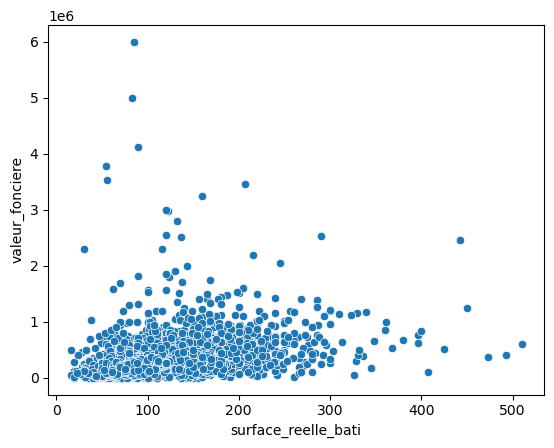

In [385]:
sns.scatterplot(data=df_maison, x='surface_reelle_bati',y='valeur_fonciere')

In [ ]:
# outliers valeur subjective

In [ ]:
df_maison[df_maison['valeur_fonciere']>2000000]

In [403]:
drop_ind = df_maison[(df_maison['valeur_fonciere']>2000000)].index

In [405]:
df_maison = df_maison.drop(drop_ind,axis=0)

<Axes: xlabel='surface_reelle_bati', ylabel='valeur_fonciere'>

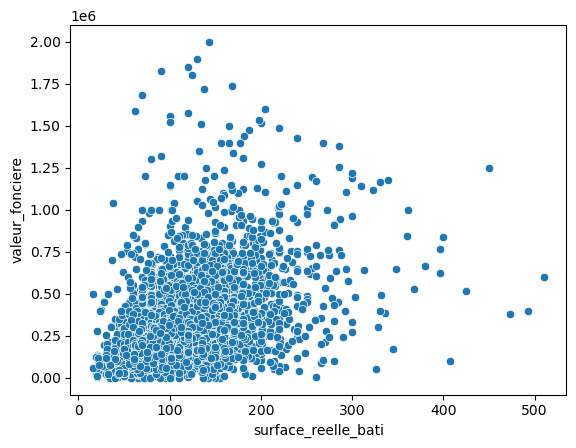

In [407]:
sns.scatterplot(data=df_maison, x='surface_reelle_bati',y='valeur_fonciere')

In [415]:
drop_ind = df_maison[(df_maison['surface_terrain']>5000)].index
df_maison = df_maison.drop(drop_ind,axis=0)

<Axes: xlabel='surface_terrain', ylabel='valeur_fonciere'>

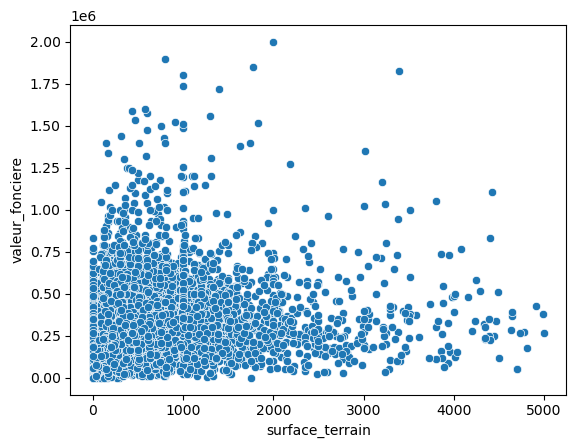

In [417]:
sns.scatterplot(data=df_maison, x='surface_terrain',y='valeur_fonciere')

<Axes: xlabel='nombre_pieces_principales', ylabel='valeur_fonciere'>

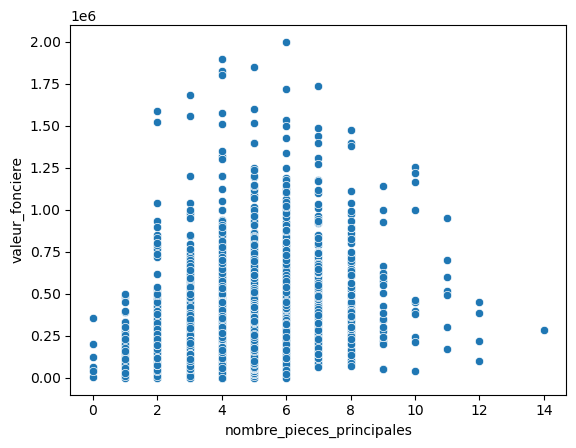

In [300]:
sns.scatterplot(data=df_maison, x='nombre_pieces_principales',y='valeur_fonciere')

In [419]:
df_maison.corr(numeric_only = True)['valeur_fonciere'].sort_values()

month                       -0.025936
surface_terrain              0.184521
nombre_pieces_principales    0.383316
surface_reelle_bati          0.474200
valeur_fonciere              1.000000
year                              NaN
Name: valeur_fonciere, dtype: float64

In [433]:
df_maison['code_postal'].value_counts()

code_postal
31600    377
31200    294
31700    287
31470    277
31140    252
        ... 
31540     28
31280     27
31850     24
31580     23
31670     15
Name: count, Length: 70, dtype: int64

In [447]:
df_maison_31600 = df_maison[df_maison['code_postal'] == '31600']

<Axes: xlabel='surface_reelle_bati', ylabel='valeur_fonciere'>

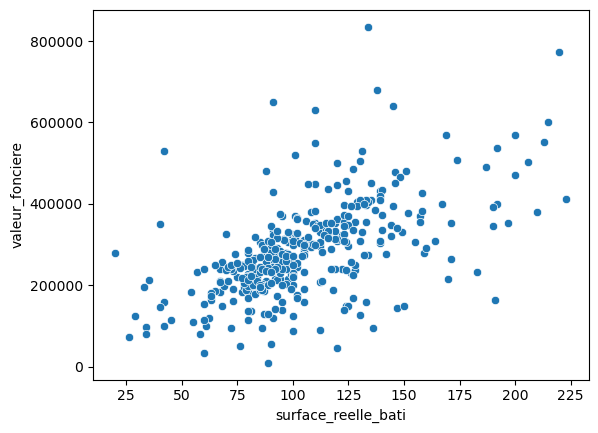

In [449]:
sns.scatterplot(data=df_maison_31600, x='surface_reelle_bati',y='valeur_fonciere')

In [451]:
def calculate_correlation(group):
    return group['valeur_fonciere'].corr(group['surface_reelle_bati'])

In [461]:
correlation_by_postal_code = df.groupby('code_postal').apply(calculate_correlation)

for code_postal, correlation in correlation_by_postal_code.items():
    if correlation >= 0.6:
        print(f'Code Postal: {code_postal}, Corrélation: {correlation:.2f}')

Code Postal: 31110, Corrélation: 0.69
Code Postal: 31120, Corrélation: 0.77
Code Postal: 31140, Corrélation: 0.71
Code Postal: 31170, Corrélation: 0.66
Code Postal: 31180, Corrélation: 0.81
Code Postal: 31190, Corrélation: 0.70
Code Postal: 31240, Corrélation: 0.60
Code Postal: 31250, Corrélation: 0.62
Code Postal: 31270, Corrélation: 0.70
Code Postal: 31280, Corrélation: 0.72
Code Postal: 31320, Corrélation: 0.68
Code Postal: 31330, Corrélation: 0.70
Code Postal: 31340, Corrélation: 0.66
Code Postal: 31380, Corrélation: 0.64
Code Postal: 31400, Corrélation: 0.63
Code Postal: 31450, Corrélation: 0.61
Code Postal: 31470, Corrélation: 0.65
Code Postal: 31480, Corrélation: 0.64
Code Postal: 31490, Corrélation: 0.77
Code Postal: 31530, Corrélation: 0.82
Code Postal: 31540, Corrélation: 0.80
Code Postal: 31560, Corrélation: 0.80
Code Postal: 31580, Corrélation: 0.74
Code Postal: 31600, Corrélation: 0.65
Code Postal: 31650, Corrélation: 0.74
Code Postal: 31660, Corrélation: 0.74
Code Postal:

In [459]:
for code_postal, correlation in correlation_by_postal_code.items():
    if correlation < 0.6:
        print(f'Code Postal: {code_postal}, Corrélation: {correlation:.2f}')

Code Postal: 31000, Corrélation: 0.50
Code Postal: 31100, Corrélation: 0.59
Code Postal: 31130, Corrélation: 0.40
Code Postal: 31150, Corrélation: 0.51
Code Postal: 31160, Corrélation: 0.47
Code Postal: 31200, Corrélation: 0.27
Code Postal: 31210, Corrélation: 0.47
Code Postal: 31220, Corrélation: 0.46
Code Postal: 31230, Corrélation: 0.33
Code Postal: 31260, Corrélation: 0.36
Code Postal: 31290, Corrélation: 0.54
Code Postal: 31300, Corrélation: 0.39
Code Postal: 31310, Corrélation: 0.46
Code Postal: 31350, Corrélation: 0.48
Code Postal: 31360, Corrélation: 0.59
Code Postal: 31370, Corrélation: 0.47
Code Postal: 31390, Corrélation: 0.10
Code Postal: 31410, Corrélation: 0.55
Code Postal: 31420, Corrélation: 0.33
Code Postal: 31430, Corrélation: 0.37
Code Postal: 31440, Corrélation: 0.21
Code Postal: 31460, Corrélation: 0.60
Code Postal: 31500, Corrélation: 0.31
Code Postal: 31510, Corrélation: 0.59
Code Postal: 31520, Corrélation: 0.51
Code Postal: 31550, Corrélation: 0.39
Code Postal: